In [1]:
import pandas as pd
import numpy as np
from conlleval import evaluate

# Data Prep

## Word Data

In [2]:
x = pd.read_csv('joint_corpus_with_pos.csv')

### Words

In [3]:
sents = x.groupby('sent')[['corpus_form', 'POS_CONC', 'NER']].apply(lambda x: x.values.tolist())
sents[:5]

sent
1    [[נראה, VB, O], [שאביטל, REL|NNP, I_PERS], [אב...
2    [[תורג'מן, NNP, I_PERS], [,, yyCM, O], [שכבר, ...
3    [[הפגישה, VB, O], [המרגשת, DEF|JJ, O], [בין, I...
4    [[בשלב, PREPOSITION|DEF|NN, O], [מאוחר, RB, O]...
5    [[אברג'יל, NNP, I_PERS], [,, yyCM, O], [נבוכה,...
dtype: object

In [4]:
words = list(set(x["corpus_form"].values))
n_words = len(words); n_words

18755

In [5]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

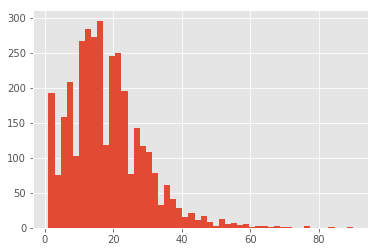

In [6]:
plt.hist([len(s) for s in list(sents)], bins=50)
plt.show()

In [7]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}

In [8]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sents]

Using TensorFlow backend.


In [9]:
X = pad_sequences(maxlen=max_len, sequences=X, value=word2idx["PAD"], padding='post', truncating='post')

In [10]:
X[1]

array([12093, 11454,  3745,  2052, 16390,   216, 12797, 14340,  4704,
       11296,  9501, 13735, 18418, 11454,   203, 13333, 10143,  6367,
        6308, 15341,  8905,  8151,  8905,   227, 11454, 16219,  6603,
        8152,  9558, 15296,  7856,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

### Part of Speech

In [11]:
pos = list(set(x["POS_CONC"].values))
n_pos = len(pos); n_pos

276

In [12]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0
X_pos = [[pos2idx[w[1]] for w in s] for s in sents]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos[0]

array([247, 266,  62, 109, 142,  62, 241, 113, 164, 142, 142, 247, 103,
        62,  62, 109, 152,  59, 200, 105,  59, 241, 113,  28, 142, 201,
        77,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

### "Gold" Tags

In [13]:
tags = list(set(x["NER"].values))
n_tags = len(tags); n_tags

18

In [14]:
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [15]:
y = [[tag2idx[w[2]] for w in s] for s in sents]
y_numer = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [16]:
y_numer[1]

array([ 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  3,  3, 15, 15,  4,  4,
       15, 15, 15, 15,  8, 15, 11, 15, 15, 15, 15,  3, 15, 15,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [17]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y_numer]
y[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
from sklearn.model_selection import train_test_split

splits = [train_test_split(X, y, X_pos, test_size=0.15, random_state=42+i) for i in range(3)]

### Prep char input

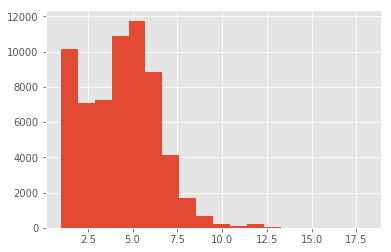

In [19]:
x.corpus_form.apply(len).hist(bins=18)

In [20]:
max_len_char = 10

In [21]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

101


In [22]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [23]:
X_char = []
for sentence in sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [24]:
splits_char = [train_test_split(X_char, y, test_size=0.15, random_state=42+i) for i in range(3)]

### Model

In [25]:
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

# Model Builder

In [26]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, Concatenate
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras_contrib.layers import CRF
from keras_contrib.metrics import crf_accuracy
from keras_contrib.losses import crf_loss

In [27]:
def plot_histories(histories, crf=False, **kwargs):
    for h in histories:
        plt.figure()
        if crf:
            plt.plot(h["crf_accuracy"])
            plt.plot(h["val_crf_accuracy"]) 
        else:   
            plt.plot(h["acc"])
            plt.plot(h["val_acc"])
        plt.show()
        
def predict_test_sentence(splits, models, words, i, use_word=True, use_pos=True, use_char=False, **kwargs):
    for split, model in zip(splits, models):
        if use_char:
            split, char_split = split
            X_char_tr, X_char_te, _, _ = char_split
        X_tr, X_te, y_tr, y_te, pos_tr, pos_te = split
        params = []
        if use_word:
            params.append(np.array([X_te[i]]))
        if use_pos:
            params.append(np.array([pos_te[i]]))
        if use_char:
            params.append(np.array([X_char_te[i]]))
        p = model.predict(params)
        p = np.argmax(p, axis=-1)
        t = np.argmax(y_te[i], axis=-1)
        print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
        for w, pred, tr in zip(X_te[i], p[0], t):
            if idx2word[w]!="PAD":
                print("{:15} ({:5}): {}".format(idx2word[w], idx2tag[tr], idx2tag[pred]))
                
def predict_on_splits(splits, models, words, use_word=True, use_pos=False, use_char=False, predict_on_train=False, **kwargs):
    all_cat_preds = []
    all_cat_y_te = []
    all_words_flat = []
    for split, model in zip(splits, models):
        split, char_split = split
        X_char_tr, X_char_te, _, _ = char_split
        X_tr, X_te, y_tr, y_te, pos_tr, pos_te = split
        
        if predict_on_train:
            X_te, y_te, pos_te = X_tr, y_tr, pos_tr
        params = []
        if use_word:
            params.append(np.array(X_te))
        if use_pos:
            params.append(np.array(pos_te))
        if use_char:
            params.append(np.array(X_char_te))
        preds = model.predict(params)
        preds = np.argmax(preds, axis=-1)
        cat_preds = []
        cat_y_te = []
        words_flat = []
        y_te_num = np.argmax(y_te, axis=-1)
        for ws, s, t in zip(X_te, preds, y_te_num):
            for w, pred, tr in zip(ws, s, t):
                if idx2word[w]!="PAD":
                    words_flat.append(idx2word[w])
                    cat_preds.append(idx2tag[pred].replace('_', '-'))
                    cat_y_te.append(idx2tag[tr].replace('_', '-'))

        all_cat_preds.append(cat_preds)
        all_cat_y_te.append(cat_y_te)
        all_words_flat.append(words_flat)
        
    return (all_cat_preds, all_cat_y_te, all_words_flat)
    
def replace_pad_with_o(ll):
    new_ll = ['O' if label=='PAD' else label for label in ll]
    return new_ll

In [28]:
def create_model(words, chars, use_word=True, use_pos=False, embedding_matrix=None, 
                       embed_dim=70, trainable=True, input_dropout=False, stack_lstm=1,
                       epochs=100, early_stopping=True, patience=20, min_delta=0.0005,
                       use_char=False, crf=False,
                       stack_cross=False, stack_double=False, rec_dropout=0.1):

    X_tr, X_te, y_tr, y_te, pos_tr, pos_te = words
    X_char_tr, X_char_te, _, _ = chars
    all_input_embeds = []
    all_inputs = []
    train_data = []
    if use_word:
        input = Input(shape=(max_len,))
        if embedding_matrix is not None:
            input_embed = Embedding(input_dim=n_words+2, output_dim=embed_dim, input_length=max_len, 
                                weights=[embedding_matrix], trainable=trainable)(input)
        else:
            input_embed = Embedding(input_dim=n_words+2, output_dim=embed_dim, input_length=max_len)(input)
        all_input_embeds.append(input_embed)
        all_inputs.append(input)
        train_data.append(X_tr)
    if use_pos:
        pos_input = Input(shape=(max_len,))
        pos_embed = Embedding(input_dim=n_pos+1, output_dim=10, input_length=max_len)(pos_input)
        all_input_embeds.append(pos_embed)
        all_inputs.append(pos_input)
        train_data.append(pos_tr)
    if use_char:
        # input and embeddings for characters
        char_in = Input(shape=(max_len, max_len_char,))
        emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=20,
                                   input_length=max_len_char))(char_in)
        # character LSTM to get word encodings by characters
        char_enc = TimeDistributed(Bidirectional(LSTM(units=10, return_sequences=False,
                                        recurrent_dropout=0.5)))(emb_char)
        all_input_embeds.append(char_enc)
        all_inputs.append(char_in)
        train_data.append(np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)))
    if len(all_inputs)>1:
        model = Concatenate()(all_input_embeds)
        if (use_char):
            model = SpatialDropout1D(0.3)(model)
    else: 
        model = all_input_embeds[0]
        all_input_embeds = all_input_embeds[0]
        all_inputs = all_inputs[0]
        train_data = train_data[0]

    if input_dropout:
        model = Dropout(0.1)(model)

    if stack_double:
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(model)
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(front)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(model)
        model = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(back)
    if stack_cross:
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(model)
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(front)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(model)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(back)
        model = concatenate([back, front])
    for i in range(stack_lstm):
        model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout))(model)

    if crf:
        model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
        crf = CRF(n_tags+1)
        loss = crf_loss
        metric = crf_accuracy
        monitor = 'val_crf_accuracy'
        out = crf(model)
    else:
        out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)  # softmax output layer
        loss = "categorical_crossentropy"
        metric = 'accuracy'
        monitor = 'val_acc'

    model = Model(all_inputs, out)
    model.compile(optimizer="rmsprop", loss=loss, metrics=[metric])
    if early_stopping:
        es = [EarlyStopping(monitor=monitor, mode='max', verbose=1, patience=patience, restore_best_weights=True, min_delta=min_delta)]
    else:
        es=None
    history = model.fit(train_data, np.array(y_tr), batch_size=32, epochs=epochs, 
                        validation_split=0.1, verbose=1, callbacks=es)
    hist = pd.DataFrame(history.history)
        
    return model, hist


## FastText

In [29]:
!ls '../fasttext/'

wiki.he.vec


In [30]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
with open('../fasttext/wiki.he.vec', encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 488937 word vectors


In [31]:
MAX_NB_WORDS = 100000
embed_dim = 300

In [32]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word2idx))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1721


In [33]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['סמאיזדט' 'תיסכולים' 'וברגשי' 'כשבליינית' '5.4' 'ולמעשיכם' '10'
 'בדיסקאונט' 'להתפדח' 'וממולדבה']


In [34]:
results = []
configs = [
            {'use_pos': False },
            {'use_pos': True},
            {'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': False},
            {'crf': True, 'use_pos': True},
            {'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'use_char': True, 'use_word': False, 'use_pos': False },
            {'use_char': True, 'use_word': False, 'use_pos': True},
            {'use_char': True, 'use_pos': False },
            {'use_char': True, 'use_pos': True},
            {'use_char': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_char': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'use_char': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_char': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': False},
            {'use_char': True, 'crf': True, 'use_pos': True},
            {'use_char': True, 'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
          ]

Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 33s 12ms/step - loss: 0.2557 - acc: 0.9563 - val_loss: 0.0907 - val_acc: 0.9745
Epoch 2/100
2663/2663 [==============================] - 31s 12ms/step - loss: 0.0653 - acc: 0.9816 - val_loss: 0.0552 - val_acc: 0.9847
Epoch 3/100
2663/2663 [==============================] - 33s 12ms/step - loss: 0.0449 - acc: 0.9872 - val_loss: 0.0470 - val_acc: 0.9866
Epoch 4/100
2663/2663 [==============================] - 29s 11ms/step - loss: 0.0350 - acc: 0.9895 - val_loss: 0.0459 - val_acc: 0.9874
Epoch 5/100
2663/2663 [==============================] - 29s 11ms/step - loss: 0.0285 - acc: 0.9914 - val_loss: 0.0401 - val_acc: 0.9888
Epoch 6/100
2663/2663 [==============================] - 30s 11ms/step - loss: 0.0235 - acc: 0.9926 - val_loss: 0.0374 - val_acc: 0.9896
Epoch 7/100
2663/2663 [==============================] - 29s 11ms/step - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0365 - val_acc: 0

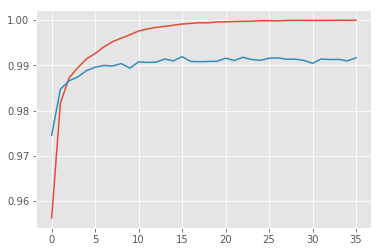

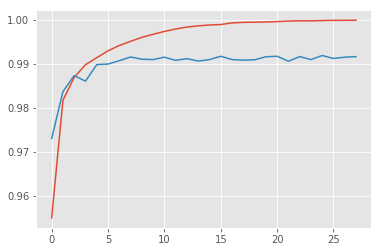

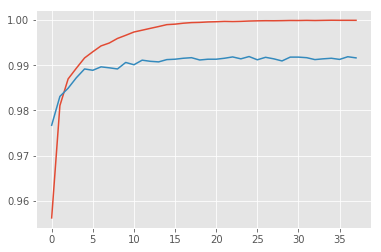

processed 9385 tokens with 778 phrases; found: 768 phrases; correct: 588.
accuracy:  81.99%; (non-O)
accuracy:  96.97%; precision:  76.56%; recall:  75.58%; FB1:  76.07
             DATE: precision:  71.67%; recall:  72.88%; FB1:  72.27  60
              LOC: precision:  76.40%; recall:  80.00%; FB1:  78.16  178
        MISC--AFF: precision:  90.59%; recall:  90.59%; FB1:  90.59  85
        MISC--ENT: precision:  33.33%; recall:  30.00%; FB1:  31.58  9
       MISC-EVENT: precision:  44.44%; recall:  80.00%; FB1:  57.14  9
            MONEY: precision:  96.77%; recall:  96.77%; FB1:  96.77  31
              ORG: precision:  61.07%; recall:  56.88%; FB1:  58.90  149
          PERCENT: precision:  87.50%; recall:  96.55%; FB1:  91.80  32
             PERS: precision:  82.46%; recall:  79.09%; FB1:  80.74  211
             TIME: precision:  50.00%; recall:  22.22%; FB1:  30.77  4
processed 9003 tokens with 779 phrases; found: 744 phrases; correct: 534.
accuracy:  78.14%; (non-O)
accuracy: 

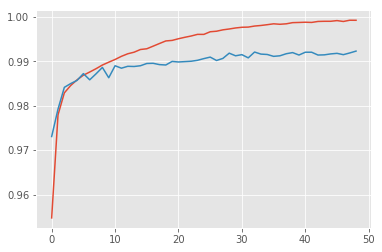

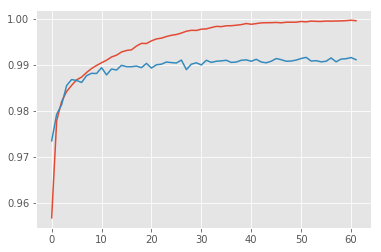

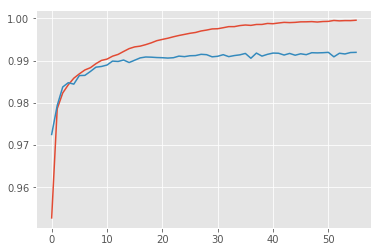

processed 9385 tokens with 778 phrases; found: 747 phrases; correct: 575.
accuracy:  79.63%; (non-O)
accuracy:  96.68%; precision:  76.97%; recall:  73.91%; FB1:  75.41
             DATE: precision:  70.18%; recall:  67.80%; FB1:  68.97  57
              LOC: precision:  80.37%; recall:  77.06%; FB1:  78.68  163
        MISC--AFF: precision:  86.81%; recall:  92.94%; FB1:  89.77  91
        MISC--ENT: precision:  50.00%; recall:  30.00%; FB1:  37.50  6
       MISC-EVENT: precision:  66.67%; recall:  80.00%; FB1:  72.73  6
            MONEY: precision:  80.00%; recall:  90.32%; FB1:  84.85  35
              ORG: precision:  60.54%; recall:  55.62%; FB1:  57.98  147
          PERCENT: precision:  96.55%; recall:  96.55%; FB1:  96.55  29
             PERS: precision:  82.13%; recall:  77.27%; FB1:  79.63  207
             TIME: precision:  50.00%; recall:  33.33%; FB1:  40.00  6
processed 9003 tokens with 779 phrases; found: 798 phrases; correct: 587.
accuracy:  82.14%; (non-O)
accuracy: 

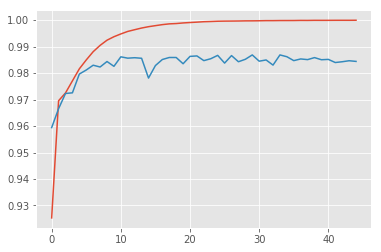

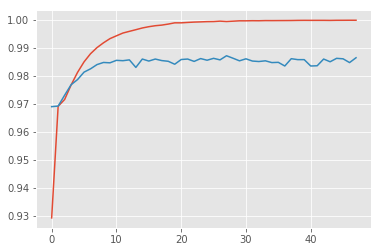

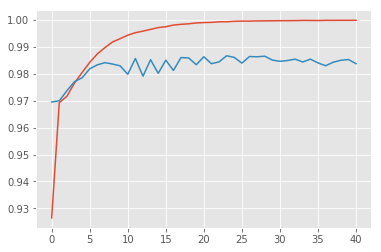

processed 9385 tokens with 778 phrases; found: 767 phrases; correct: 495.
accuracy:  69.40%; (non-O)
accuracy:  94.71%; precision:  64.54%; recall:  63.62%; FB1:  64.08
             DATE: precision:  62.71%; recall:  62.71%; FB1:  62.71  59
              LOC: precision:  70.07%; recall:  60.59%; FB1:  64.98  147
        MISC--AFF: precision:  63.64%; recall:  74.12%; FB1:  68.48  99
        MISC--ENT: precision:   0.00%; recall:   0.00%; FB1:   0.00  6
       MISC-EVENT: precision:  19.05%; recall:  80.00%; FB1:  30.77  21
            MONEY: precision:  85.71%; recall:  77.42%; FB1:  81.36  28
              ORG: precision:  49.17%; recall:  55.62%; FB1:  52.20  181
          PERCENT: precision:  87.50%; recall:  96.55%; FB1:  91.80  32
             PERS: precision:  76.84%; recall:  66.36%; FB1:  71.22  190
             TIME: precision:  25.00%; recall:  11.11%; FB1:  15.38  4
processed 9003 tokens with 779 phrases; found: 807 phrases; correct: 519.
accuracy:  72.13%; (non-O)
accuracy:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2663/2663 [==============================] - 26s 10ms/step - loss: 4.2089e-04 - acc: 0.9999 - val_loss: 0.1014 - val_acc: 0.9825
Restoring model weights from the end of the best epoch
Epoch 00042: early stopping


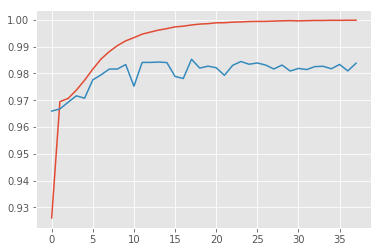

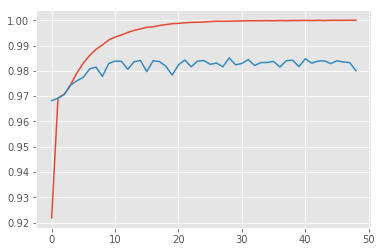

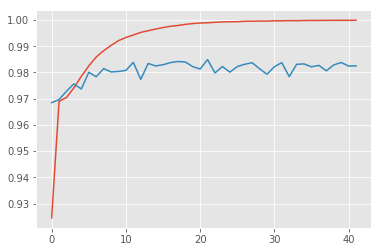

processed 9385 tokens with 778 phrases; found: 701 phrases; correct: 464.
accuracy:  64.92%; (non-O)
accuracy:  94.45%; precision:  66.19%; recall:  59.64%; FB1:  62.75
             DATE: precision:  64.81%; recall:  59.32%; FB1:  61.95  54
              LOC: precision:  66.88%; recall:  60.59%; FB1:  63.58  154
        MISC--AFF: precision:  68.48%; recall:  74.12%; FB1:  71.19  92
        MISC--ENT: precision:   8.33%; recall:  10.00%; FB1:   9.09  12
       MISC-EVENT: precision:  18.18%; recall:  40.00%; FB1:  25.00  11
            MONEY: precision:  84.00%; recall:  67.74%; FB1:  75.00  25
              ORG: precision:  62.39%; recall:  45.62%; FB1:  52.71  117
          PERCENT: precision:  62.79%; recall:  93.10%; FB1:  75.00  43
             PERS: precision:  72.40%; recall:  63.18%; FB1:  67.48  192
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
processed 9003 tokens with 779 phrases; found: 717 phrases; correct: 460.
accuracy:  66.55%; (non-O)
accuracy

In [ ]:
for conf in configs[::-1][8:]:
    mh = [create_model(split, char, **conf) for split, char in zip(splits, splits_char)]
    hists = [h for m, h in mh]
    models = [m for m, h in mh]
    plot_histories(hists, **conf)
    all_cat_preds, all_cat_y_te, all_words_flat = predict_on_splits(zip(splits, splits_char), models, words, **conf)
    all_cat_preds = [replace_pad_with_o(ll) for ll in all_cat_preds]
    res = []
    for cat_y_te, cat_preds in zip(all_cat_y_te, all_cat_preds):
        res.append(evaluate(cat_y_te, cat_preds))
    results.append(res)
    

In [40]:
for c in configs:
    if 'embedding_matrix' in c:
        c.update({'embedding_matrix': 'fastext'}) 

In [47]:
defaults = {'use_word': True, 'use_pos': False, 'embedding_matrix': None, 
            'embed_dim': 70, 'trainable': True, 'input_dropout': False, 
            'stack_lstm': 1, 'epochs': 100, 'early_stopping': True, 'patience': 20, 
            'min_delta': 0.0005, 'use_char': False, 'crf': False, 'stack_cross': False, 
            'stack_double': False, 'rec_dropout': 0.1}

In [45]:
third_results = pickle.load(open('third_results.pkl', 'rb'))

In [46]:
second_results = pickle.load(open('second_results.pkl', 'rb'))

In [126]:
configs2 = [
            {'use_char': True, 'crf': True, 'use_word': False, 'use_pos': False },
            {'use_char': True, 'crf': True, 'use_word': False, 'use_pos': True},
          ]

Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 89s 33ms/step - loss: 0.4976 - crf_accuracy: 0.8577 - val_loss: 0.2182 - val_crf_accuracy: 0.9482
Epoch 2/100
2663/2663 [==============================] - 34s 13ms/step - loss: 0.1737 - crf_accuracy: 0.9622 - val_loss: 0.1695 - val_crf_accuracy: 0.9639
Epoch 3/100
2663/2663 [==============================] - 32s 12ms/step - loss: 0.1463 - crf_accuracy: 0.9687 - val_loss: 0.1538 - val_crf_accuracy: 0.9657
Epoch 4/100
2663/2663 [==============================] - 32s 12ms/step - loss: 0.1348 - crf_accuracy: 0.9694 - val_loss: 0.1429 - val_crf_accuracy: 0.9656
Epoch 5/100
2663/2663 [==============================] - 32s 12ms/step - loss: 0.1285 - crf_accuracy: 0.9693 - val_loss: 0.1361 - val_crf_accuracy: 0.9659
Epoch 6/100
2663/2663 [==============================] - 35s 13ms/step - loss: 0.1233 - crf_accuracy: 0.9695 - val_loss: 0.1320 - val_crf_accuracy: 0.9660
Epoch 7/100
2663/2663 [

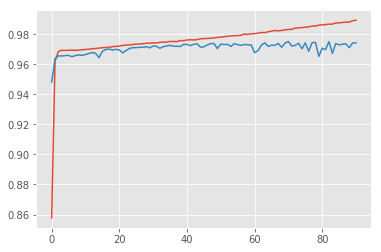

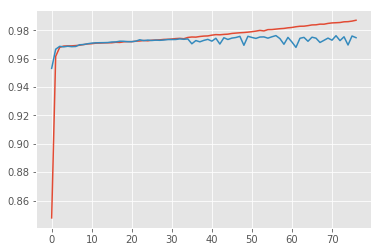

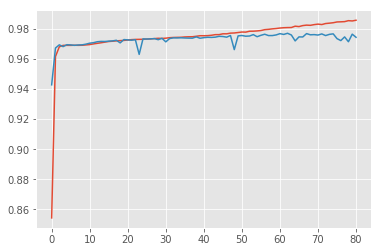

processed 9385 tokens with 778 phrases; found: 411 phrases; correct: 239.
accuracy:  33.14%; (non-O)
accuracy:  90.42%; precision:  58.15%; recall:  30.72%; FB1:  40.20
             DATE: precision:  81.08%; recall:  50.85%; FB1:  62.50  37
              LOC: precision:  46.32%; recall:  25.88%; FB1:  33.21  95
        MISC--AFF: precision:  63.79%; recall:  43.53%; FB1:  51.75  58
        MISC--ENT: precision:  50.00%; recall:  10.00%; FB1:  16.67  2
       MISC-EVENT: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            MONEY: precision:  79.17%; recall:  61.29%; FB1:  69.09  24
              ORG: precision:  40.68%; recall:  15.00%; FB1:  21.92  59
          PERCENT: precision: 100.00%; recall: 100.00%; FB1: 100.00  29
             PERS: precision:  51.40%; recall:  25.00%; FB1:  33.64  107
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 9003 tokens with 779 phrases; found: 450 phrases; correct: 253.
accuracy:  32.67%; (non-O)
accuracy:  8

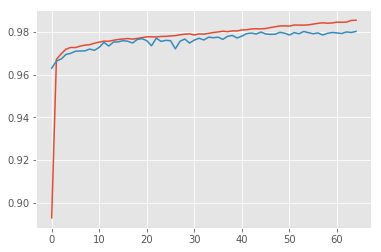

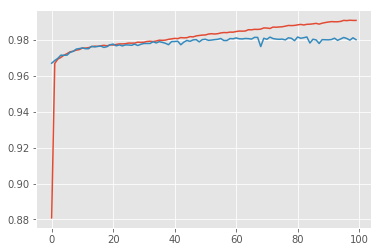

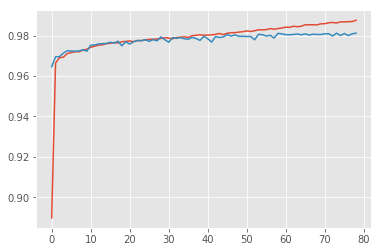

processed 9385 tokens with 778 phrases; found: 545 phrases; correct: 319.
accuracy:  44.97%; (non-O)
accuracy:  91.85%; precision:  58.53%; recall:  41.00%; FB1:  48.22
             DATE: precision:  70.73%; recall:  49.15%; FB1:  58.00  41
              LOC: precision:  48.78%; recall:  35.29%; FB1:  40.96  123
        MISC--AFF: precision:  60.66%; recall:  43.53%; FB1:  50.68  61
        MISC--ENT: precision: 100.00%; recall:  10.00%; FB1:  18.18  1
       MISC-EVENT: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            MONEY: precision:  95.24%; recall:  64.52%; FB1:  76.92  21
              ORG: precision:  47.54%; recall:  18.12%; FB1:  26.24  61
          PERCENT: precision:  87.88%; recall: 100.00%; FB1:  93.55  33
             PERS: precision:  55.88%; recall:  51.82%; FB1:  53.77  204
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 9003 tokens with 779 phrases; found: 641 phrases; correct: 398.
accuracy:  54.27%; (non-O)
accuracy:  

In [128]:
results2 = []
for conf in configs2:
    mh = [create_model(split, char, **conf) for split, char in zip(splits, splits_char)]
    hists = [h for m, h in mh]
    models = [m for m, h in mh]
    plot_histories(hists, **conf)
    all_cat_preds, all_cat_y_te, all_words_flat = predict_on_splits(zip(splits, splits_char), models, words, **conf)
    all_cat_preds = [replace_pad_with_o(ll) for ll in all_cat_preds]
    res = []
    for cat_y_te, cat_preds in zip(all_cat_y_te, all_cat_preds):
        res.append(evaluate(cat_y_te, cat_preds))
    results2.append(res)
    

In [53]:
fourth_results = pickle.load(open('fourth_results.pkl', 'rb'))

In [48]:
configs3 = [c for c in configs if ('crf' in c) and not ('trainable' in c and not c['trainable']) ]

Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 44s 17ms/step - loss: 0.3333 - crf_accuracy: 0.9384 - val_loss: 0.1798 - val_crf_accuracy: 0.9657
Epoch 2/100
2663/2663 [==============================] - 39s 15ms/step - loss: 0.1458 - crf_accuracy: 0.9697 - val_loss: 0.1558 - val_crf_accuracy: 0.9662
Epoch 3/100
2663/2663 [==============================] - 37s 14ms/step - loss: 0.1060 - crf_accuracy: 0.9722 - val_loss: 0.1172 - val_crf_accuracy: 0.9717
Epoch 4/100
2663/2663 [==============================] - 38s 14ms/step - loss: 0.0832 - crf_accuracy: 0.9767 - val_loss: 0.1076 - val_crf_accuracy: 0.9728
Epoch 5/100
2663/2663 [==============================] - 37s 14ms/step - loss: 0.0682 - crf_accuracy: 0.9804 - val_loss: 0.1016 - val_crf_accuracy: 0.9753
Epoch 6/100
2663/2663 [==============================] - 37s 14ms/step - loss: 0.0562 - crf_accuracy: 0.9842 - val_loss: 0.1125 - val_crf_accuracy: 0.9674
Epoch 7/100
2663/2663 [

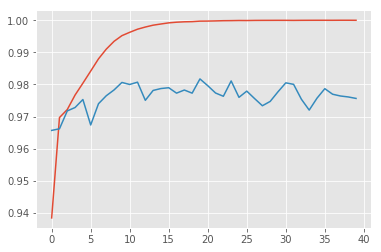

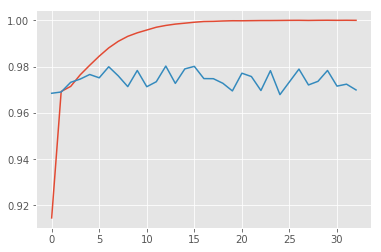

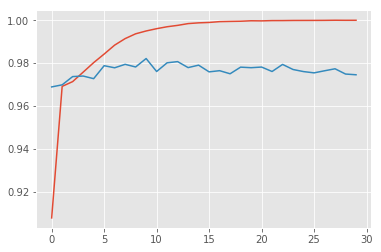

processed 9385 tokens with 778 phrases; found: 759 phrases; correct: 399.
accuracy:  59.09%; (non-O)
accuracy:  92.10%; precision:  52.57%; recall:  51.29%; FB1:  51.92
             DATE: precision:  67.92%; recall:  61.02%; FB1:  64.29  53
              LOC: precision:  75.00%; recall:  54.71%; FB1:  63.27  124
        MISC--AFF: precision:  83.58%; recall:  65.88%; FB1:  73.68  67
        MISC--ENT: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
       MISC-EVENT: precision:  11.11%; recall:  40.00%; FB1:  17.39  18
            MONEY: precision:  46.15%; recall:  38.71%; FB1:  42.11  26
              ORG: precision:  45.07%; recall:  40.00%; FB1:  42.38  142
          PERCENT: precision:  45.45%; recall:  34.48%; FB1:  39.22  22
             PERS: precision:  50.61%; recall:  56.82%; FB1:  53.53  247
             TIME: precision:   1.75%; recall:  11.11%; FB1:   3.03  57
processed 9003 tokens with 779 phrases; found: 757 phrases; correct: 410.
accuracy:  60.71%; (non-O)
accuracy

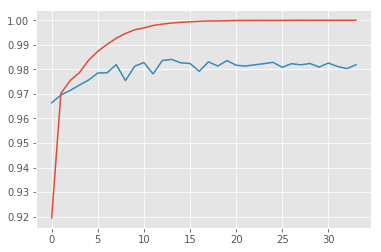

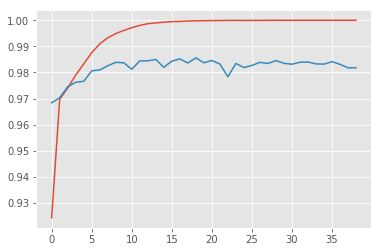

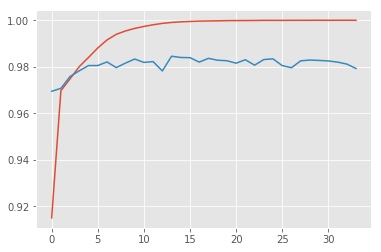

processed 9385 tokens with 778 phrases; found: 755 phrases; correct: 471.
accuracy:  66.86%; (non-O)
accuracy:  94.06%; precision:  62.38%; recall:  60.54%; FB1:  61.45
             DATE: precision:  47.14%; recall:  55.93%; FB1:  51.16  70
              LOC: precision:  72.48%; recall:  63.53%; FB1:  67.71  149
        MISC--AFF: precision:  73.97%; recall:  63.53%; FB1:  68.35  73
        MISC--ENT: precision:  50.00%; recall:  10.00%; FB1:  16.67  2
       MISC-EVENT: precision:   9.52%; recall:  40.00%; FB1:  15.38  21
            MONEY: precision:  70.97%; recall:  70.97%; FB1:  70.97  31
              ORG: precision:  40.33%; recall:  45.62%; FB1:  42.82  181
          PERCENT: precision:  73.68%; recall:  96.55%; FB1:  83.58  38
             PERS: precision:  78.95%; recall:  68.18%; FB1:  73.17  190
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 9003 tokens with 779 phrases; found: 741 phrases; correct: 488.
accuracy:  65.94%; (non-O)
accuracy:

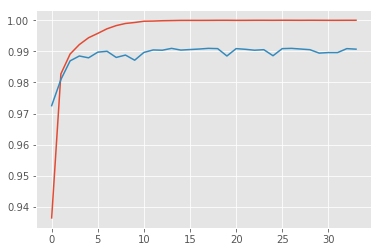

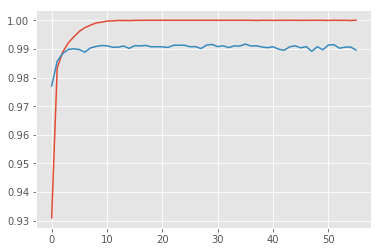

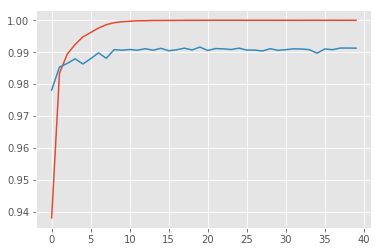

processed 9385 tokens with 778 phrases; found: 751 phrases; correct: 573.
accuracy:  80.64%; (non-O)
accuracy:  96.68%; precision:  76.30%; recall:  73.65%; FB1:  74.95
             DATE: precision:  63.08%; recall:  69.49%; FB1:  66.13  65
              LOC: precision:  76.92%; recall:  76.47%; FB1:  76.70  169
        MISC--AFF: precision:  92.50%; recall:  87.06%; FB1:  89.70  80
        MISC--ENT: precision:  25.00%; recall:  30.00%; FB1:  27.27  12
       MISC-EVENT: precision:  57.14%; recall:  80.00%; FB1:  66.67  7
            MONEY: precision:  90.62%; recall:  93.55%; FB1:  92.06  32
              ORG: precision:  65.97%; recall:  59.38%; FB1:  62.50  144
          PERCENT: precision:  90.48%; recall:  65.52%; FB1:  76.00  21
             PERS: precision:  80.65%; recall:  79.55%; FB1:  80.09  217
             TIME: precision:  75.00%; recall:  33.33%; FB1:  46.15  4
processed 9003 tokens with 779 phrases; found: 790 phrases; correct: 565.
accuracy:  79.44%; (non-O)
accuracy:

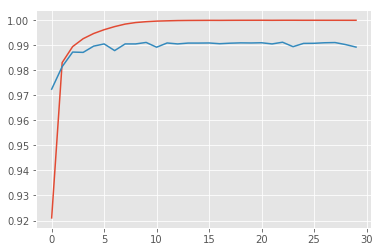

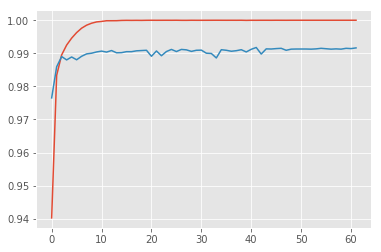

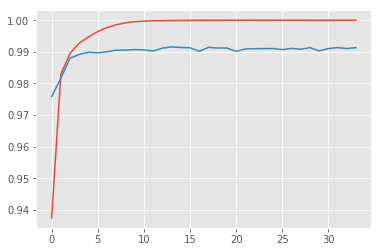

processed 9385 tokens with 778 phrases; found: 768 phrases; correct: 579.
accuracy:  81.15%; (non-O)
accuracy:  96.61%; precision:  75.39%; recall:  74.42%; FB1:  74.90
             DATE: precision:  60.66%; recall:  62.71%; FB1:  61.67  61
              LOC: precision:  77.51%; recall:  77.06%; FB1:  77.29  169
        MISC--AFF: precision:  93.83%; recall:  89.41%; FB1:  91.57  81
        MISC--ENT: precision:  50.00%; recall:  10.00%; FB1:  16.67  2
       MISC-EVENT: precision:  50.00%; recall:  80.00%; FB1:  61.54  8
            MONEY: precision:  93.55%; recall:  93.55%; FB1:  93.55  31
              ORG: precision:  57.49%; recall:  60.00%; FB1:  58.72  167
          PERCENT: precision:  89.29%; recall:  86.21%; FB1:  87.72  28
             PERS: precision:  81.57%; recall:  80.45%; FB1:  81.01  217
             TIME: precision:  75.00%; recall:  33.33%; FB1:  46.15  4
processed 9003 tokens with 779 phrases; found: 783 phrases; correct: 582.
accuracy:  81.79%; (non-O)
accuracy: 

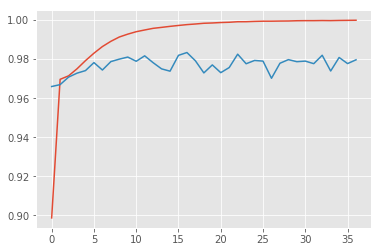

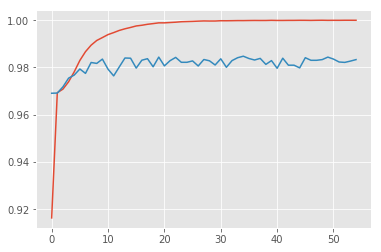

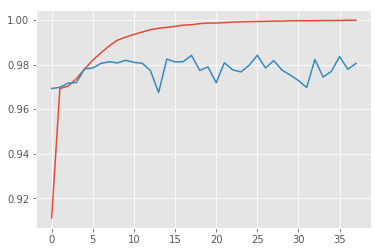

processed 9385 tokens with 778 phrases; found: 711 phrases; correct: 439.
accuracy:  64.50%; (non-O)
accuracy:  93.67%; precision:  61.74%; recall:  56.43%; FB1:  58.97
             DATE: precision:  61.29%; recall:  64.41%; FB1:  62.81  62
              LOC: precision:  53.98%; recall:  55.88%; FB1:  54.91  176
        MISC--AFF: precision:  84.72%; recall:  71.76%; FB1:  77.71  72
        MISC--ENT: precision:   5.88%; recall:  10.00%; FB1:   7.41  17
       MISC-EVENT: precision:   7.14%; recall:  20.00%; FB1:  10.53  14
            MONEY: precision:  80.00%; recall:  77.42%; FB1:  78.69  30
              ORG: precision:  47.24%; recall:  37.50%; FB1:  41.81  127
          PERCENT: precision:  63.16%; recall:  82.76%; FB1:  71.64  38
             PERS: precision:  77.01%; recall:  60.91%; FB1:  68.02  174
             TIME: precision: 100.00%; recall:  11.11%; FB1:  20.00  1
processed 9003 tokens with 779 phrases; found: 775 phrases; correct: 507.
accuracy:  71.25%; (non-O)
accuracy

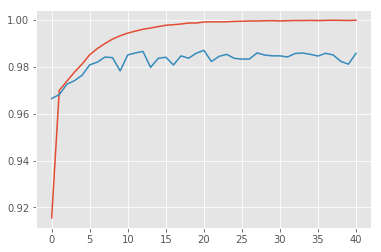

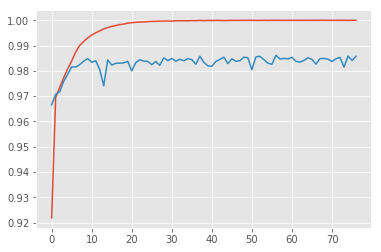

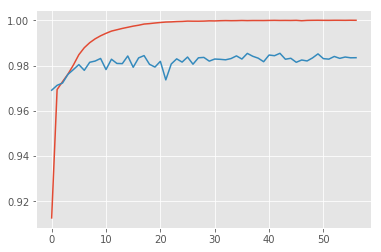

processed 9385 tokens with 778 phrases; found: 733 phrases; correct: 501.
accuracy:  69.65%; (non-O)
accuracy:  94.96%; precision:  68.35%; recall:  64.40%; FB1:  66.31
             DATE: precision:  60.61%; recall:  67.80%; FB1:  64.00  66
              LOC: precision:  77.14%; recall:  63.53%; FB1:  69.68  140
        MISC--AFF: precision:  78.05%; recall:  75.29%; FB1:  76.65  82
        MISC--ENT: precision:   7.69%; recall:  10.00%; FB1:   8.70  13
       MISC-EVENT: precision:  50.00%; recall:  60.00%; FB1:  54.55  6
            MONEY: precision:  80.77%; recall:  67.74%; FB1:  73.68  26
              ORG: precision:  54.32%; recall:  55.00%; FB1:  54.66  162
          PERCENT: precision:  89.29%; recall:  86.21%; FB1:  87.72  28
             PERS: precision:  71.90%; recall:  68.64%; FB1:  70.23  210
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 9003 tokens with 779 phrases; found: 820 phrases; correct: 550.
accuracy:  74.83%; (non-O)
accuracy:

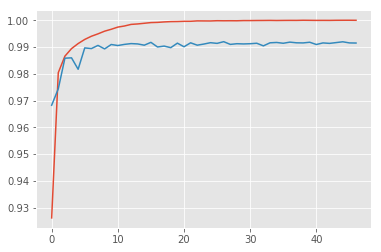

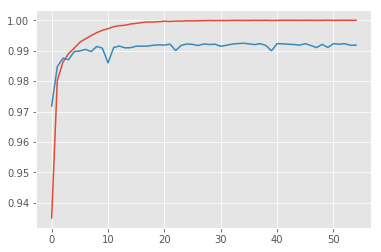

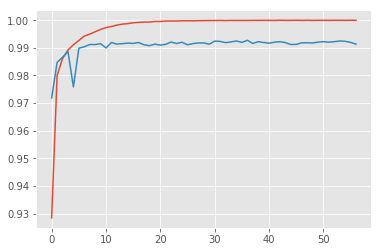

processed 9385 tokens with 778 phrases; found: 784 phrases; correct: 615.
accuracy:  83.60%; (non-O)
accuracy:  97.10%; precision:  78.44%; recall:  79.05%; FB1:  78.75
             DATE: precision:  69.35%; recall:  72.88%; FB1:  71.07  62
              LOC: precision:  81.33%; recall:  79.41%; FB1:  80.36  166
        MISC--AFF: precision:  91.01%; recall:  95.29%; FB1:  93.10  89
        MISC--ENT: precision:  50.00%; recall:  40.00%; FB1:  44.44  8
       MISC-EVENT: precision:  42.86%; recall:  60.00%; FB1:  50.00  7
            MONEY: precision:  96.77%; recall:  96.77%; FB1:  96.77  31
              ORG: precision:  63.69%; recall:  62.50%; FB1:  63.09  157
          PERCENT: precision:  80.00%; recall:  96.55%; FB1:  87.50  35
             PERS: precision:  84.75%; recall:  85.91%; FB1:  85.33  223
             TIME: precision:  33.33%; recall:  22.22%; FB1:  26.67  6
processed 9003 tokens with 779 phrases; found: 830 phrases; correct: 612.
accuracy:  84.23%; (non-O)
accuracy: 

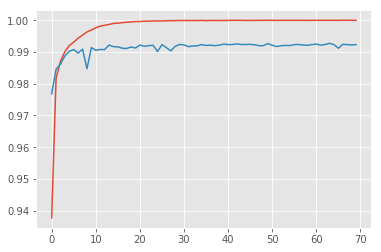

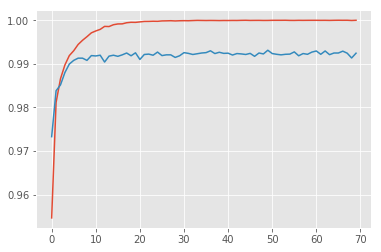

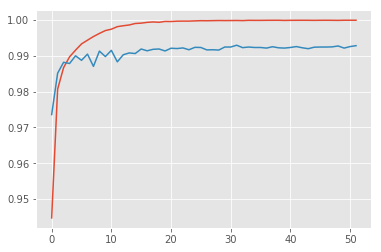

processed 9385 tokens with 778 phrases; found: 797 phrases; correct: 636.
accuracy:  85.46%; (non-O)
accuracy:  97.25%; precision:  79.80%; recall:  81.75%; FB1:  80.76
             DATE: precision:  79.03%; recall:  83.05%; FB1:  80.99  62
              LOC: precision:  76.50%; recall:  82.35%; FB1:  79.32  183
        MISC--AFF: precision:  92.13%; recall:  96.47%; FB1:  94.25  89
        MISC--ENT: precision:  33.33%; recall:  60.00%; FB1:  42.86  18
       MISC-EVENT: precision:  71.43%; recall: 100.00%; FB1:  83.33  7
            MONEY: precision:  93.75%; recall:  96.77%; FB1:  95.24  32
              ORG: precision:  74.65%; recall:  66.25%; FB1:  70.20  142
          PERCENT: precision:  96.67%; recall: 100.00%; FB1:  98.31  30
             PERS: precision:  81.22%; recall:  84.55%; FB1:  82.85  229
             TIME: precision:  60.00%; recall:  33.33%; FB1:  42.86  5
processed 9003 tokens with 779 phrases; found: 766 phrases; correct: 607.
accuracy:  83.45%; (non-O)
accuracy:

In [36]:
results3 = []
for conf in configs3:
    mh = [create_model(split, char, min_delta=0.0001, **conf) for split, char in zip(splits, splits_char)]
    hists = [h for m, h in mh]
    models = [m for m, h in mh]
    plot_histories(hists, **conf)
    all_cat_preds, all_cat_y_te, all_words_flat = predict_on_splits(zip(splits, splits_char), models, words, **conf)
    all_cat_preds = [replace_pad_with_o(ll) for ll in all_cat_preds]
    res = []
    for cat_y_te, cat_preds in zip(all_cat_y_te, all_cat_preds):
        res.append(evaluate(cat_y_te, cat_preds))
    results3.append(res)
    

In [49]:
for c in configs3:
    if 'embedding_matrix' in c:
        c.update({'embedding_matrix': 'fastext'}) 
    c.update({'min_delta': 0.0001})

In [50]:
import pickle
with open('fifth_results.pkl', 'wb') as f:
    pickle.dump(list(zip(configs3, results3)), f)

In [51]:
fifth_results = pickle.load(open('fifth_results.pkl', 'rb'))

In [80]:
all_results = second_results + third_results + fourth_results + fifth_results

In [81]:
for conf, res in all_results:
    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]
all_results[-2:]

[({'use_char': True,
   'crf': True,
   'use_pos': False,
   'embedding_matrix': 'fastext',
   'trainable': True,
   'embed_dim': 300,
   'min_delta': 0.0001,
   'use_word': True,
   'input_dropout': False,
   'stack_lstm': 1,
   'epochs': 100,
   'early_stopping': True,
   'patience': 20,
   'stack_cross': False,
   'stack_double': False,
   'rec_dropout': 0.1,
   'use_morpheme': False},
  [(78.4438775510204, 79.04884318766067, 78.74519846350832),
   (73.73493975903614, 78.5622593068036, 76.07209446861405),
   (78.17460317460318, 75.28662420382166, 76.70343932511358)]),
 ({'use_char': True,
   'crf': True,
   'use_pos': True,
   'embedding_matrix': 'fastext',
   'trainable': True,
   'embed_dim': 300,
   'min_delta': 0.0001,
   'use_word': True,
   'input_dropout': False,
   'stack_lstm': 1,
   'epochs': 100,
   'early_stopping': True,
   'patience': 20,
   'stack_cross': False,
   'stack_double': False,
   'rec_dropout': 0.1,
   'use_morpheme': False},
  [(79.79924717691343, 81.74807

In [83]:
import pickle
with open('all_results_dict.pkl', 'rb') as f:
    all_results = pickle.load(f)

In [84]:
with open('morpheme_results.pkl', 'rb') as f:
    morpheme_results = pickle.load(f)

In [85]:
with open('morpheme_results_2.pkl', 'rb') as f:
    morpheme_results2 = pickle.load(f)

In [86]:
with open('morpheme_results_3.pkl', 'rb') as f:
    morpheme_results3 = pickle.load(f)

In [87]:
with open('morpheme_results_4.pkl', 'rb') as f:
    morpheme_results4 = pickle.load(f)

In [88]:
with open('morpheme_results_5.pkl', 'rb') as f:
    morpheme_results5 = pickle.load(f)

for conf, res in morpheme_results5:
    conf.update({'min_delta': 0.0002})


In [89]:
with open('morpheme_results_6.pkl', 'rb') as f:
    morpheme_results6 = pickle.load(f)
    
for conf, res in morpheme_results5:
    conf.update({'min_delta': 0.0001})

In [90]:
morpheme_results = morpheme_results + morpheme_results2 + morpheme_results3 + morpheme_results4[:-1] + morpheme_results5 + morpheme_results6

In [91]:
for conf, res in morpheme_results:
    conf.update({'use_morpheme': True})
    conf.update({'use_word': False})

    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]
morpheme_results[-2:]

[({'use_char': True,
   'crf': True,
   'use_pos': False,
   'embedding_matrix': 'fastext',
   'trainable': True,
   'embed_dim': 300,
   'use_morpheme': True,
   'use_word': False,
   'input_dropout': False,
   'stack_lstm': 1,
   'epochs': 100,
   'early_stopping': True,
   'patience': 20,
   'min_delta': 0.0005,
   'stack_cross': False,
   'stack_double': False,
   'rec_dropout': 0.1},
  [(78.89908256880734, 77.77777777777779, 78.33441769681198),
   (81.11702127659575, 78.40616966580977, 79.73856209150327),
   (79.97382198952879, 77.93367346938776, 78.9405684754522)]),
 ({'use_char': True,
   'crf': True,
   'use_pos': True,
   'embedding_matrix': 'fastext',
   'trainable': True,
   'embed_dim': 300,
   'use_morpheme': True,
   'use_word': False,
   'input_dropout': False,
   'stack_lstm': 1,
   'epochs': 100,
   'early_stopping': True,
   'patience': 20,
   'min_delta': 0.0005,
   'stack_cross': False,
   'stack_double': False,
   'rec_dropout': 0.1},
  [(81.87830687830689, 79.9741

In [92]:
defaults.update({'use_morpheme': False})

In [93]:
for conf, res in all_results:
    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]
all_results[-2:]

[({'use_char': True,
   'crf': True,
   'use_pos': False,
   'embedding_matrix': 'fastext',
   'trainable': True,
   'embed_dim': 300,
   'min_delta': 0.0001,
   'use_word': True,
   'input_dropout': False,
   'stack_lstm': 1,
   'epochs': 100,
   'early_stopping': True,
   'patience': 20,
   'stack_cross': False,
   'stack_double': False,
   'rec_dropout': 0.1,
   'use_morpheme': False},
  [(78.4438775510204, 79.04884318766067, 78.74519846350832),
   (73.73493975903614, 78.5622593068036, 76.07209446861405),
   (78.17460317460318, 75.28662420382166, 76.70343932511358)]),
 ({'use_char': True,
   'crf': True,
   'use_pos': True,
   'embedding_matrix': 'fastext',
   'trainable': True,
   'embed_dim': 300,
   'min_delta': 0.0001,
   'use_word': True,
   'input_dropout': False,
   'stack_lstm': 1,
   'epochs': 100,
   'early_stopping': True,
   'patience': 20,
   'stack_cross': False,
   'stack_double': False,
   'rec_dropout': 0.1,
   'use_morpheme': False},
  [(79.79924717691343, 81.74807

In [94]:
all_results=all_results+morpheme_results

In [95]:
import pandas as pd

In [96]:
dict_res = []
for conf, res in all_results:
    dr = {}
    for i, r in enumerate(res):
        split_name = chr(ord('a')+i)
        dr['prec_'+split_name], dr['recall_'+split_name], dr['f1_'+split_name] = r
    dr.update(conf)
    dict_res.append(dr)
rdf = (pd.DataFrame(dict_res)
       .assign(prec = lambda x: (x.prec_a + x.prec_b + x.prec_c)/3)
       .assign(recall = lambda x: (x.recall_a + x.recall_b + x.recall_c)/3)
       .assign(f1 = lambda x: (x.f1_a + x.f1_b + x.f1_c)/3))

In [97]:
drop_cols = ['embed_dim','stack_lstm', 'epochs', 'early_stopping', 'patience', 
            'min_delta', 'stack_cross', 'input_dropout',
            'stack_double', 'rec_dropout'] + [c for c in rdf.columns if c.endswith(('_a', '_b', '_c'))]
drop_cols

['embed_dim',
 'stack_lstm',
 'epochs',
 'early_stopping',
 'patience',
 'min_delta',
 'stack_cross',
 'input_dropout',
 'stack_double',
 'rec_dropout',
 'f1_a',
 'f1_b',
 'f1_c',
 'prec_a',
 'prec_b',
 'prec_c',
 'recall_a',
 'recall_b',
 'recall_c']

In [98]:
rdf.sort_values('f1', ascending=False).drop(columns=drop_cols, axis=1).head(20).T

,63,55,62,1,54,0,53,35,3,34,2,6,49,52,43,47,59,7,31,14
crf,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,False,True,False,True,True
embedding_matrix,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext
trainable,True,True,True,False,False,True,True,True,False,True,True,True,True,False,True,True,True,False,True,True
use_char,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,False,True,False,False
use_morpheme,True,True,True,False,True,False,True,False,False,False,False,False,True,True,True,True,True,False,False,False
use_pos,True,True,False,True,True,True,False,True,False,False,False,True,True,False,True,False,True,True,True,True
use_word,False,False,False,True,False,True,False,True,True,True,True,True,False,False,False,False,False,True,True,True
prec,80.8956,80.8722,79.9966,80.359,79.316,78.4289,79.3381,78.3439,80.6314,76.7845,77.6282,76.3014,74.3849,77.6247,73.4612,74.2939,73.7319,75.1355,75.0383,73.5895
recall,79.5409,79.0741,78.0392,77.3715,77.9972,78.5244,77.5758,78.4882,76.2636,77.6326,76.2669,76.4364,77.1879,73.3035,77.0152,76.117,76.2881,74.132,74.0421,74.8969
f1,80.2101,79.9458,79.0045,78.8368,78.6499,78.4663,78.4374,78.4103,78.3862,77.1736,76.9168,76.3583,75.7547,75.3504,75.1914,75.1776,74.9829,74.6276,74.5325,74.2325


In [99]:
rdf[~rdf.use_char].sort_values('f1', ascending=False).drop(columns=drop_cols, axis=1).head(20).T

,43,59,31,14,20,16,30,15,58,22,41,42,17,21,40,23,39,29,24,57
crf,True,True,True,True,False,True,True,True,True,False,False,True,True,False,False,False,True,True,False,True
embedding_matrix,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,fastext,None,None,None,None
trainable,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,False,True,True,True,True
use_char,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
use_morpheme,True,True,False,False,False,False,False,False,True,False,True,True,False,False,True,False,True,False,False,True
use_pos,True,True,True,True,True,False,False,True,False,False,True,False,False,True,False,False,True,True,True,True
use_word,False,False,True,True,True,True,True,True,False,True,False,False,True,True,False,True,False,True,True,False
prec,73.4612,73.7319,75.0383,73.5895,73.3952,75.3004,73.3304,74.8944,70.9597,73.0542,69.7735,71.0445,71.9813,71.4026,66.3374,68.9643,66.4531,63.822,61.0689,61.2827
recall,77.0152,76.2881,74.0421,74.8969,74.6793,71.8678,73.3973,71.3553,74.0692,71.8217,74.4844,69.284,68.1039,68.446,70.0823,65.9288,62.3729,60.0423,62.3039,59.2219
f1,75.1914,74.9829,74.5325,74.2325,74.0283,73.5357,73.351,73.0712,72.4745,72.4271,72.0424,70.1339,69.9789,69.8805,68.1551,67.3972,64.3389,61.8594,61.6705,60.2058


In [100]:
rdf[rdf.embedding_matrix.isna()].sort_values('f1', ascending=False).drop(columns=drop_cols, axis=1).head(20).T

,61,51,50,33,60,39,45,10,4,29,24,11,32,57,18,5,44,25,37,56
crf,True,True,True,True,True,True,False,False,True,True,False,False,True,True,True,True,False,False,False,True
embedding_matrix,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
trainable,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
use_char,True,True,True,True,True,False,True,True,True,False,False,True,True,False,False,True,True,False,False,False
use_morpheme,True,True,True,False,True,True,True,False,False,False,False,False,False,True,False,False,True,False,True,True
use_pos,True,True,False,True,False,True,True,True,True,True,True,False,False,True,True,False,False,False,True,False
use_word,False,False,False,True,False,False,False,True,True,True,True,True,True,False,True,True,False,True,False,False
prec,68.4798,69.0237,68.9733,64.9639,67.7901,66.4531,64.6962,63.8986,62.9083,63.822,61.0689,65.0322,62.0996,61.2827,60.8984,59.8485,56.6353,59.3365,56.0667,58.653
recall,66.6594,64.0014,62.7661,65.9339,63.119,62.3729,63.8355,64.6051,61.232,60.0423,62.3039,58.2046,58.5076,59.2219,58.7146,56.3569,58.7594,53.6278,56.6295,52.1444
f1,67.5559,66.4095,65.6971,65.3991,65.322,64.3389,64.2466,64.2433,62.0384,61.8594,61.6705,61.4187,60.2249,60.2058,59.7843,57.9432,57.6545,56.3361,56.3065,55.2036


In [101]:
rdf[(rdf.embedding_matrix.isna())].sort_values('f1', ascending=False).drop(columns=drop_cols, axis=1).head(20).T

,61,51,50,33,60,39,45,10,4,29,24,11,32,57,18,5,44,25,37,56
crf,True,True,True,True,True,True,False,False,True,True,False,False,True,True,True,True,False,False,False,True
embedding_matrix,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
trainable,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
use_char,True,True,True,True,True,False,True,True,True,False,False,True,True,False,False,True,True,False,False,False
use_morpheme,True,True,True,False,True,True,True,False,False,False,False,False,False,True,False,False,True,False,True,True
use_pos,True,True,False,True,False,True,True,True,True,True,True,False,False,True,True,False,False,False,True,False
use_word,False,False,False,True,False,False,False,True,True,True,True,True,True,False,True,True,False,True,False,False
prec,68.4798,69.0237,68.9733,64.9639,67.7901,66.4531,64.6962,63.8986,62.9083,63.822,61.0689,65.0322,62.0996,61.2827,60.8984,59.8485,56.6353,59.3365,56.0667,58.653
recall,66.6594,64.0014,62.7661,65.9339,63.119,62.3729,63.8355,64.6051,61.232,60.0423,62.3039,58.2046,58.5076,59.2219,58.7146,56.3569,58.7594,53.6278,56.6295,52.1444
f1,67.5559,66.4095,65.6971,65.3991,65.322,64.3389,64.2466,64.2433,62.0384,61.8594,61.6705,61.4187,60.2249,60.2058,59.7843,57.9432,57.6545,56.3361,56.3065,55.2036


In [103]:
#rdf.to_pickle('all_results.df.pkl')

In [104]:
#rdf.to_csv('all_results.csv', index=False)

In [105]:
rtable = (rdf[(~rdf.embedding_matrix.isna()) & (rdf.trainable) & (rdf.crf)
     & (~((rdf.use_char) 
          & (~rdf.use_word) 
          & (~rdf.use_morpheme)))]
 .groupby(['use_morpheme', 'use_char', 'use_pos'])
 .apply(lambda x: x.f1.max())
 .unstack(level=[-1,-2])
 .round(1)
 #.sort_index(axis=1, level=['use_char', 'use_pos', 'trainable'])
)
rtable

use_pos,False,True,False,True
use_char,False,False,True,True
use_morpheme,,,,
False,73.5,74.5,77.2,78.5
True,72.5,75.2,79.0,80.2


In [107]:
rtable = (rdf[(~rdf.embedding_matrix.isna()) & (rdf.trainable) & (rdf.crf)
     & (~((rdf.use_char) 
          & (~rdf.use_word) 
          & (~rdf.use_morpheme)))]
 .groupby(['use_morpheme', 'use_char', 'use_pos'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[-1,-2])
 .round(1)
 #.sort_index(axis=1, level=['use_char', 'use_pos', 'trainable'])
)
rtable

use_pos,False,True,False,True
use_char,False,False,True,True
use_morpheme,,,,
False,73.4,74.4,77.0,78.4
True,71.3,75.1,78.7,80.1


In [106]:
rtable = (rdf[(rdf.embedding_matrix.isna()) & (rdf.trainable) & (rdf.crf)
     & (~((rdf.use_char) 
          & (~rdf.use_word) 
          & (~rdf.use_morpheme)))]
 .groupby(['use_morpheme', 'use_char', 'use_pos'])
 .apply(lambda x: x.f1.max())
 .unstack(level=[-1,-2])
 .round(1)
 #.sort_index(axis=1, level=['use_char', 'use_pos', 'trainable'])
)
rtable

use_pos,False,True,False,True
use_char,False,False,True,True
use_morpheme,,,,
False,51.9,61.9,60.2,65.4
True,55.2,64.3,65.7,67.6


In [108]:
rtable = (rdf[(rdf.embedding_matrix.isna()) & (rdf.trainable) & (rdf.crf)
     & (~((rdf.use_char) 
          & (~rdf.use_word) 
          & (~rdf.use_morpheme)))]
 .groupby(['use_morpheme', 'use_char', 'use_pos'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[-1,-2])
 .round(1)
 #.sort_index(axis=1, level=['use_char', 'use_pos', 'trainable'])
)
rtable

use_pos,False,True,False,True
use_char,False,False,True,True
use_morpheme,,,,
False,50.6,60.8,59.1,63.7
True,54.9,62.3,65.5,67.0


In [268]:
rtable = (rdf[(rdf.embedding_matrix.isna()) & (rdf.trainable) & (rdf.crf)
     & (~((rdf.use_char) 
          & (~rdf.use_word) 
          & (~rdf.use_morpheme)))]
 .groupby(['use_morpheme', 'use_char', 'use_pos'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[-1,-2])
 .round(1)
 #.sort_index(axis=1, level=['use_char', 'use_pos', 'trainable'])
)
rtable

use_pos,False,True,False,True
use_char,False,False,True,True
use_morpheme,,,,
False,72.4,74.0,73.8,76.4
True,68.2,72.0,75.2,75.8


In [229]:
rtable = (rdf[(rdf.embedding_matrix.isna()) & (rdf.trainable) & (~rdf.crf)
     & (~((rdf.use_char) 
          & (~rdf.use_word) 
          & (~rdf.use_morpheme)))]
 .groupby(['use_morpheme', 'use_char', 'use_pos'])
 .apply(lambda x: x.f1.max())
 .unstack(level=[-1,-2])
 .round(1)
 #.sort_index(axis=1, level=['use_char', 'use_pos', 'trainable'])
)
rtable

use_pos,False,True,False,True
use_char,False,False,True,True
use_morpheme,,,,
False,56.3,61.7,61.4,64.2
True,54.9,56.3,57.7,64.2


In [120]:
important_cols = ['crf', 'embedding_matrix', 'trainable', 'use_char', 'use_pos', 'use_word', 'use_morpheme']
pd.concat([rdf.fillna('NONE').groupby(f).f1.mean() for f in important_cols], keys=important_cols).unstack()

,False,True,NONE,fastext
crf,64.935365,67.492623,NaN,NaN
embedding_matrix,NaN,NaN,56.788732,73.544753
trainable,73.606602,64.508008,NaN,NaN
use_char,65.238683,67.467965,NaN,NaN
use_pos,64.153761,68.274227,NaN,NaN
use_word,64.482623,69.099612,NaN,NaN
use_morpheme,65.405399,66.842901,NaN,NaN


In [40]:
rdf_fast = rdf[rdf.embedding_matrix=='fastext']
pd.concat([rdf_fast.groupby(f).f1.mean() for f in important_cols], keys=important_cols).unstack().assign(ratio = lambda x: x[True]/x[False] -1 )

,False,True,fastext,ratio
crf,72.230399,74.874956,NaN,0.036613
embedding_matrix,NaN,NaN,73.552678,NaN
trainable,73.224107,73.771725,NaN,0.007479
use_char,71.672844,76.372428,NaN,0.065570
use_pos,72.431822,74.673534,NaN,0.030949
use_word,71.380720,74.095667,NaN,0.038035
use_morpheme,74.095667,71.380720,NaN,-0.036641


In [45]:
rdf_fast = rdf[rdf.embedding_matrix!='fastext']
pd.concat([rdf_fast.groupby(f).f1.mean() for f in important_cols], keys=important_cols).unstack().assign(ratio = lambda x: x[True]/x[False] -1 )

,False,True,ratio
crf,54.767652,55.831482,0.019424
trainable,NaN,55.299567,NaN
use_char,57.282273,52.325509,-0.086532
use_pos,51.899428,58.699707,0.131028
use_word,52.760945,59.107501,0.120289
use_morpheme,53.818375,57.521356,0.068805


In [41]:
rdf_fast = rdf[(rdf.use_char)]
pd.concat([rdf_fast.groupby(f).f1.mean() for f in important_cols], keys=important_cols).unstack().assign(ratio = lambda x: x[True]/x[False] -1 )

,False,True,fastext,ratio
crf,63.196261,65.501676,NaN,0.036480
embedding_matrix,NaN,NaN,76.372428,NaN
trainable,76.366271,60.343201,NaN,-0.209819
use_char,NaN,64.348969,NaN,NaN
use_pos,62.130382,66.567555,NaN,0.071417
use_word,43.240124,71.385250,NaN,0.650903
use_morpheme,64.348969,NaN,NaN,NaN


In [42]:
rdf_fast = rdf[(~rdf.use_char)]
pd.concat([rdf_fast.groupby(f).f1.mean() for f in important_cols], keys=important_cols).unstack().assign(ratio = lambda x: x[True]/x[False] -1 )

,False,True,fastext,ratio
crf,63.700869,65.254248,NaN,0.024386
embedding_matrix,NaN,NaN,71.672844,NaN
trainable,70.081943,63.356682,NaN,-0.095963
use_char,64.477559,NaN,NaN,NaN
use_pos,62.189119,66.765998,NaN,0.073596
use_word,62.141144,66.813973,NaN,0.075197
use_morpheme,66.813973,62.141144,NaN,-0.069938


In [44]:
rdf_fast = rdf[(rdf.use_morpheme)]
pd.concat([rdf_fast.groupby(f).f1.mean() for f in important_cols], keys=important_cols).unstack().assign(ratio = lambda x: x[True]/x[False] -1 )

,False,True,fastext,ratio
crf,60.445122,63.837166,NaN,0.056118
embedding_matrix,NaN,NaN,71.38072,NaN
trainable,NaN,62.141144,NaN,NaN
use_char,62.141144,NaN,NaN,NaN
use_pos,59.528178,64.754110,NaN,0.087789
use_word,62.141144,NaN,NaN,NaN
use_morpheme,NaN,62.141144,NaN,NaN
